<a href="https://colab.research.google.com/github/lucasferreiraos/curso-aprendizado-de-maquina-na-pratica/blob/master/Pre%C3%A7o_do_combust%C3%ADvel_no_Brasil_regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preço do combustível no Brasil

A Agência Nacional do Petróleo, Gás Natural e Biocombustíveis (ANP) divulga relatórios semanais de preços do gás, diesel e outros combustíveis utilizados no transporte em todo o país. Esses conjuntos de dados trazem o valor médio por litro, o número de postos analisados e outras informações agrupadas por regiões e estados em todo o país.

Esse dataset contém mais de 100 mil instâncias coletadas entre 2004 e 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/content/drive/My Drive/Datasets/gas_prices_in_brazil/gas-brazil.tsv')
data.head()

,\tDATA INICIAL\tDATA FINAL\tREGIÃO\tESTADO\tPRODUTO\tNÚMERO DE POSTOS PESQUISADOS\tUNIDADE DE MEDIDA\tPREÇO MÉDIO REVENDA\tDESVIO PADRÃO REVENDA\tPREÇO MÍNIMO REVENDA\tPREÇO MÁXIMO REVENDA\tMARGEM MÉDIA REVENDA\tCOEF DE VARIAÇÃO REVENDA\tPREÇO MÉDIO DISTRIBUIÇÃO\tDESVIO PADRÃO DISTRIBUIÇÃO\tPREÇO MÍNIMO DISTRIBUIÇÃO\tPREÇO MÁXIMO DISTRIBUIÇÃO\tCOEF DE VARIAÇÃO DISTRIBUIÇÃO\tMÊS\tANO
0,0\t2004-05-09\t2004-05-15\tCENTRO OESTE\tDISTR...
1,1\t2004-05-09\t2004-05-15\tCENTRO OESTE\tGOIAS...
2,2\t2004-05-09\t2004-05-15\tCENTRO OESTE\tMATO ...
3,3\t2004-05-09\t2004-05-15\tCENTRO OESTE\tMATO ...
4,4\t2004-05-09\t2004-05-15\tNORDESTE\tALAGOAS\t...


### Formato de arquivo estranho...

Sim, é estranho. Isso porque o arquivo etá no formato `.tsv` que significa tab separate values (valores separados por tab), semelhante ao `.csv` que quer dizer comma separate values (valores separados por vírgula).

O método `read_csv()` do Pandas tem um argumento `sep` onde você pode passar como parâmetro o caractere que o arquivo usa como separador. O valor padrão é a `,` que os arquivos .csv utilizam. Para esse caso, vemos que existe uma string que se repete na separação dos valores que é o `\t`, representando o tab. Então, para obtermos um objeto `DataFrame` formatado corretamente, só precisamos carregar o arquivo da seguinte forma:


In [3]:
data = pd.read_csv('/content/drive/My Drive/Datasets/gas_prices_in_brazil/gas-brazil.tsv', sep='\t')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


Funcionou! Observe na segunda linha que existe um `.drop()` porque quando eu explicitei o separador do meu arquivo o Pandas criou uma coluna `Unnamed: 0`, então eu a removi do dataset.

Em seguida eu vou renomear as colunas - isso vai deixar a tarefa de manipular dados mais prática - e verficar se há dados faltantes.

In [4]:
data.columns

Index(['DATA INICIAL', 'DATA FINAL', 'REGIÃO', 'ESTADO', 'PRODUTO',
       'NÚMERO DE POSTOS PESQUISADOS', 'UNIDADE DE MEDIDA',
       'PREÇO MÉDIO REVENDA', 'DESVIO PADRÃO REVENDA', 'PREÇO MÍNIMO REVENDA',
       'PREÇO MÁXIMO REVENDA', 'MARGEM MÉDIA REVENDA',
       'COEF DE VARIAÇÃO REVENDA', 'PREÇO MÉDIO DISTRIBUIÇÃO',
       'DESVIO PADRÃO DISTRIBUIÇÃO', 'PREÇO MÍNIMO DISTRIBUIÇÃO',
       'PREÇO MÁXIMO DISTRIBUIÇÃO', 'COEF DE VARIAÇÃO DISTRIBUIÇÃO', 'MÊS',
       'ANO'],
      dtype='object')

In [5]:
data.columns = [
    'dataInicial', 'dataFinal', 'regiao', 'estado', 'produto',
    'numeroPostosPesquisados', 'unidadeDeMedida',
    'precoMedioRevenda', 'desvioPadraoRevenda', 'precoMinimoRevenda',
    'precoMaximoRevenda', 'margemMediaRevenda',
    'coefVariacaoRevenda', 'precoMedioDistribuicao',
    'desvioPadraoDistribuicao', 'precoMinimoDistribuicao',
    'precoMaximoDistribuicao', 'coefVariacaoDistribuicao', 'mes',
    'ano'
]

In [6]:
data.head()

,dataInicial,dataFinal,regiao,estado,produto,numeroPostosPesquisados,unidadeDeMedida,precoMedioRevenda,desvioPadraoRevenda,precoMinimoRevenda,precoMaximoRevenda,margemMediaRevenda,coefVariacaoRevenda,precoMedioDistribuicao,desvioPadraoDistribuicao,precoMinimoDistribuicao,precoMaximoDistribuicao,coefVariacaoDistribuicao,mes,ano
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


Temos duas colunas aqui que podem até serem consideradas redundantes que são as duas colunas de data. Esse dataset contém dados de relatórios semanais e então, para cada instância, foram registradas a data do início e do fim do período de coleta em cada semana e os respecitvos resultados são médias relacionadas àquele período de tempo.

Portanto, uma das colunas de data pode ser retirada e a coluna que se mostra mais "relevante" é a da data final porque com ela nós podemos fazer a leitura de que os valores médios foram obtidos no último dia de coleta na semana, que é a data final.

In [7]:
data.drop('dataInicial', axis=1, inplace=True)
data.head()

,dataFinal,regiao,estado,produto,numeroPostosPesquisados,unidadeDeMedida,precoMedioRevenda,desvioPadraoRevenda,precoMinimoRevenda,precoMaximoRevenda,margemMediaRevenda,coefVariacaoRevenda,precoMedioDistribuicao,desvioPadraoDistribuicao,precoMinimoDistribuicao,precoMaximoDistribuicao,coefVariacaoDistribuicao,mes,ano
0,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


In [8]:
data.isnull().sum()

dataFinal                   0
regiao                      0
estado                      0
produto                     0
numeroPostosPesquisados     0
unidadeDeMedida             0
precoMedioRevenda           0
desvioPadraoRevenda         0
precoMinimoRevenda          0
precoMaximoRevenda          0
margemMediaRevenda          0
coefVariacaoRevenda         0
precoMedioDistribuicao      0
desvioPadraoDistribuicao    0
precoMinimoDistribuicao     0
precoMaximoDistribuicao     0
coefVariacaoDistribuicao    0
mes                         0
ano                         0
dtype: int64

Um outro procedimento que pode ser feito na limpeza dos dados - e que pode até ser adotado como necessário junto com a verificação de dados nulos ou faltantes - é a verificação de tipos das variáveis pois, em algumas situações, pode acontecer de uma determinada coluna que contém números ser de um tipo não-numérico. Vamos ver se isso acontece nesse conjunto de dados.

In [9]:
data.dtypes

dataFinal                    object
regiao                       object
estado                       object
produto                      object
numeroPostosPesquisados       int64
unidadeDeMedida              object
precoMedioRevenda           float64
desvioPadraoRevenda         float64
precoMinimoRevenda          float64
precoMaximoRevenda          float64
margemMediaRevenda           object
coefVariacaoRevenda         float64
precoMedioDistribuicao       object
desvioPadraoDistribuicao     object
precoMinimoDistribuicao      object
precoMaximoDistribuicao      object
coefVariacaoDistribuicao     object
mes                           int64
ano                           int64
dtype: object

No código, usamos a propriedade `dtypes` para verficar o tipo de dados das colunas do nosso dataset. Aqui já é possível notar que tem algo errado! Algumas colunas que em seu nome possuem palavras como "preço", "desvio padrão" e "coeficiente" não são de um tipo numérico e isso vai dificultar a nossa vida na hora manipular esses dados como, por exemplo, na plotagem de gráficos.

As colunas que deveriam ser do tipo numérico são:
- `margemMediaRevenda`
- `precoMedioDistribuicao`
- `desvioPadraoDistribuicao`
- `precoMinimoDistribuicao`
- `precoMaximoDistribuicao`
- `coefVariacaoDistribuicao`

O que devemos fazer é transformar esses dados para o seu devido tipo.

In [10]:
data.margemMediaRevenda = pd.to_numeric(data.margemMediaRevenda, downcast='float')
data.precoMedioDistribuicao = pd.to_numeric(data.precoMedioDistribuicao, downcast='float')
data.desvioPadraoDistribuicao = pd.to_numeric(data.desvioPadraoDistribuicao, downcast='float')
data.precoMinimoDistribuicao = pd.to_numeric(data.precoMinimoDistribuicao, downcast='float')
data.precoMaximoDistribuicao = pd.to_numeric(data.precoMaximoDistribuicao, downcast='float')
data.coefVariacaoDistribuicao = pd.to_numeric(data.coefVariacaoDistribuicao, downcast='float')

ValueError: ignored

Opa, pegamos um erro nessa execução aqui! A mensagem de erro nos diz que não é possível converter essa string `"-"` que está na posição 1093. Vamos observar o que tem na linha 1903.

In [11]:
data[1903:1904]

,dataFinal,regiao,estado,produto,numeroPostosPesquisados,unidadeDeMedida,precoMedioRevenda,desvioPadraoRevenda,precoMinimoRevenda,precoMaximoRevenda,margemMediaRevenda,coefVariacaoRevenda,precoMedioDistribuicao,desvioPadraoDistribuicao,precoMinimoDistribuicao,precoMaximoDistribuicao,coefVariacaoDistribuicao,mes,ano
1903,2005-10-01,NORTE,PARA,ETANOL HIDRATADO,2,R$/l,1.694,0.283,1.69,2.09,-,0.167,-,-,-,-,-,9,2005


Observe que algumas colunas (justamente as colunas que deveriam ter um tipo numérico) estão preenchidas com um "-" onde deveriam existir números. Provavelmente essa foi a forma que o pessoal da ANP utilizou para preencher um dado faltante, por isso o pandas inferiu que essas colunas, que já observamos que estava preenchidas com números, eram do tipo `object`.

O que deve ser feito agora é substituir todas as células que foram preenchidas com "-" por `NaN` (ou por zero) e depois podemos pensar em alguma abordagem para lidar com os valores nulos.

Obs: note que o erro foi detectado na primeira linha de código que foi executada. Então, pela mensagem de erro nós não sabemos se o mesmo problema ocorre nas outras linhas mas nós sabemos que as linhas de código seguinte foram escritas para resolver o mesmo problema. Logo, se elas fossem executadas, levantariam o mesmo erro da primeira linha e por isso vamos implementar a solução para todas elas.

In [12]:
dataset_columns = [
    'margemMediaRevenda',
    'precoMedioDistribuicao',
    'desvioPadraoDistribuicao',
    'precoMinimoDistribuicao',
    'precoMaximoDistribuicao',
    'coefVariacaoDistribuicao'
]

In [13]:
for column in dataset_columns:
    data[column] = pd.to_numeric(
        data[column],
        errors='coerce',
        downcast='float'
    ).fillna(np.nan).astype('float')

In [14]:
data[1903:1904]

,dataFinal,regiao,estado,produto,numeroPostosPesquisados,unidadeDeMedida,precoMedioRevenda,desvioPadraoRevenda,precoMinimoRevenda,precoMaximoRevenda,margemMediaRevenda,coefVariacaoRevenda,precoMedioDistribuicao,desvioPadraoDistribuicao,precoMinimoDistribuicao,precoMaximoDistribuicao,coefVariacaoDistribuicao,mes,ano
1903,2005-10-01,NORTE,PARA,ETANOL HIDRATADO,2,R$/l,1.694,0.283,1.69,2.09,NaN,0.167,NaN,NaN,NaN,NaN,NaN,9,2005


Depois de eliminar o caractere indesejado observamos a mesma linha 1903 de antes e vemos que agora temos dados `NaN` no lugar. Vamos observar a frequência de dados nulos para o dataset inteiro.

In [15]:
data.isnull().sum()

dataFinal                      0
regiao                         0
estado                         0
produto                        0
numeroPostosPesquisados        0
unidadeDeMedida                0
precoMedioRevenda              0
desvioPadraoRevenda            0
precoMinimoRevenda             0
precoMaximoRevenda             0
margemMediaRevenda          3431
coefVariacaoRevenda            0
precoMedioDistribuicao      3400
desvioPadraoDistribuicao    3400
precoMinimoDistribuicao     3400
precoMaximoDistribuicao     3400
coefVariacaoDistribuicao    3400
mes                            0
ano                            0
dtype: int64

Agora os dados faltantes "apareceram" e com eles vem a tarefa de decidir o que podemos fazer com eles. Uma abordagem simples seria deletar esses dados, mas só podemos deletar de duas formas:

- removendo todas as linhas que contém pelo menos um dado `NaN`
- removendo todas as colunas que contém pelo menos um dado `NaN`

Mas antes de lidar com os dados `NaN` vamos fazer uma análise que vai nos ajudar a definir uma tarefa para os dados.

Observe que temos informações dos valores para cada tipo de combustível (etanol, gasolina, diesel, etc.) por estado e por região do Brasil. A priori podemos imaginar que podemos escolher qualquer um desses pontos de observação para seguir com o trabalho de análise e predição. Mas veja que se plotarmos uma série do dataset inteiro ela vai ser uma série bem estranha. Observe:

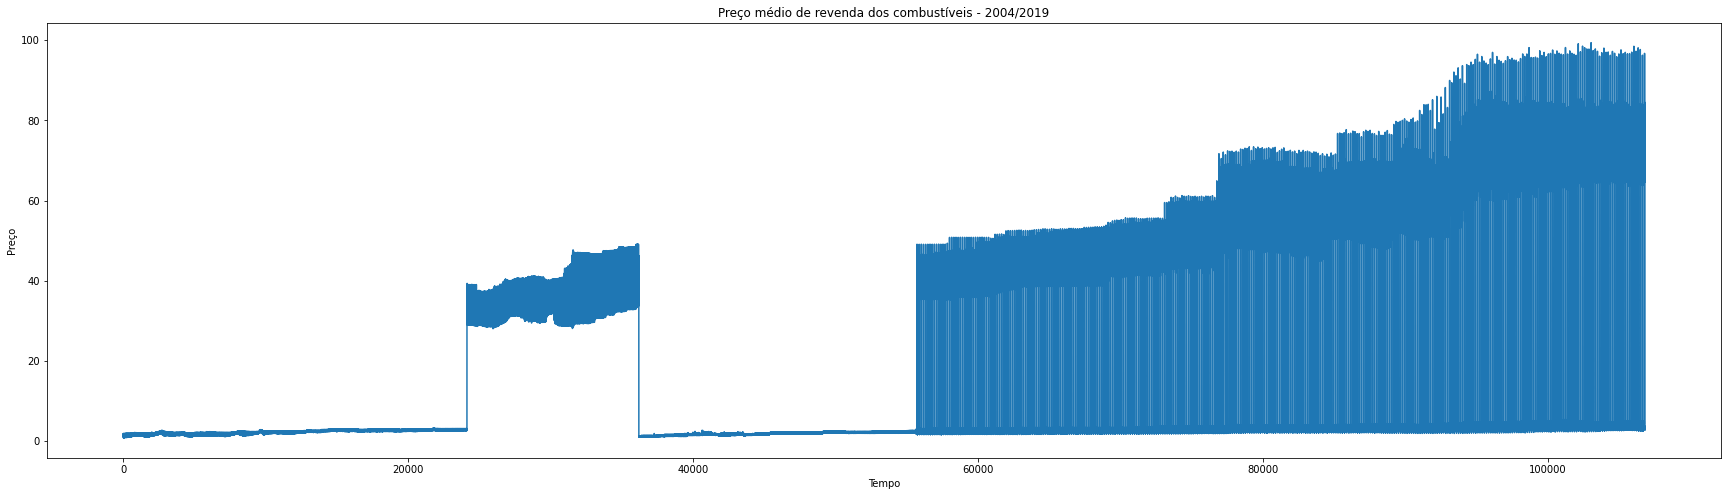

In [16]:
plt.figure(figsize=(30, 8))
plt.title("Preço médio de revenda dos combustíveis - 2004/2019")
plt.plot(data.precoMedioRevenda)
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.show()

Veja que em muitos trechos do gráfico há uma faixa azul bem densa. Mas, porquê? Vamos relembrar algumas coisas:

- Cada registro é resultado de um relatório semanal da ANP
- Essa coleta é realizada ao mesmo tempo em todos os estado do Brasil
- Os atributos a serem preenchidos são os mesmos para todos os tipos de combustível

Refletindo sobre esses pontos é possível dizer que temos vários registros para todos os estados e para todos os tipos de combustível no mesmo instante de tempo, ou seja, na mesma data. Sendo mais preciso, temos o número total de estados (26 + DF) vezes a quantidade de tipos de combustível (são 6 ao todo), o que dá um total de 162 registros para uma mesma data.

No fim das contas, o gráfico acima plotou séries temporais sobrepostas.

Observe a célula abaixo para poder entender melhor a descrição que acabei de fazer.

In [17]:
produtos = data.produto.unique()
estados = data.estado.unique()

for estado in estados:
    for produto in produtos:
        total = data.query("estado == @estado and produto == @produto").shape[0]
        print(f"{estado} - {produto}: {total} registros")

DISTRITO FEDERAL - ETANOL HIDRATADO: 785 registros
DISTRITO FEDERAL - GASOLINA COMUM: 785 registros
DISTRITO FEDERAL - GLP: 783 registros
DISTRITO FEDERAL - GNV: 9 registros
DISTRITO FEDERAL - ÓLEO DIESEL: 785 registros
DISTRITO FEDERAL - ÓLEO DIESEL S10: 336 registros
GOIAS - ETANOL HIDRATADO: 785 registros
GOIAS - GASOLINA COMUM: 785 registros
GOIAS - GLP: 784 registros
GOIAS - GNV: 186 registros
GOIAS - ÓLEO DIESEL: 785 registros
GOIAS - ÓLEO DIESEL S10: 338 registros
MATO GROSSO - ETANOL HIDRATADO: 785 registros
MATO GROSSO - GASOLINA COMUM: 785 registros
MATO GROSSO - GLP: 785 registros
MATO GROSSO - GNV: 560 registros
MATO GROSSO - ÓLEO DIESEL: 785 registros
MATO GROSSO - ÓLEO DIESEL S10: 337 registros
MATO GROSSO DO SUL - ETANOL HIDRATADO: 785 registros
MATO GROSSO DO SUL - GASOLINA COMUM: 785 registros
MATO GROSSO DO SUL - GLP: 785 registros
MATO GROSSO DO SUL - GNV: 768 registros
MATO GROSSO DO SUL - ÓLEO DIESEL: 785 registros
MATO GROSSO DO SUL - ÓLEO DIESEL S10: 338 registro

Para cada estado é exibido o número de registros associado a cada tipo de combustível. Tipos de combustível que possuem 785 registros significa que houve coleta dos dados em todas as semanas durante 15 anos.

Ainda sobre as séries... Para podermos visualizar uma série mais "limpa" precisamos escolher um estado (ou região) e um tipo de combustível. Vamos observar na célula seguinte.

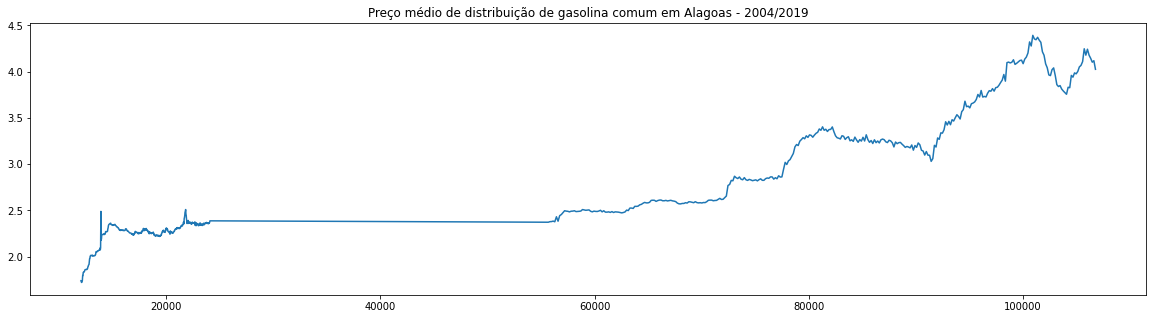

In [18]:
plt.figure(figsize=(20, 5))
plt.title('Preço médio de distribuição de gasolina comum em Alagoas - 2004/2019')
plt.plot(data.query("estado == 'ALAGOAS' and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
plt.show()

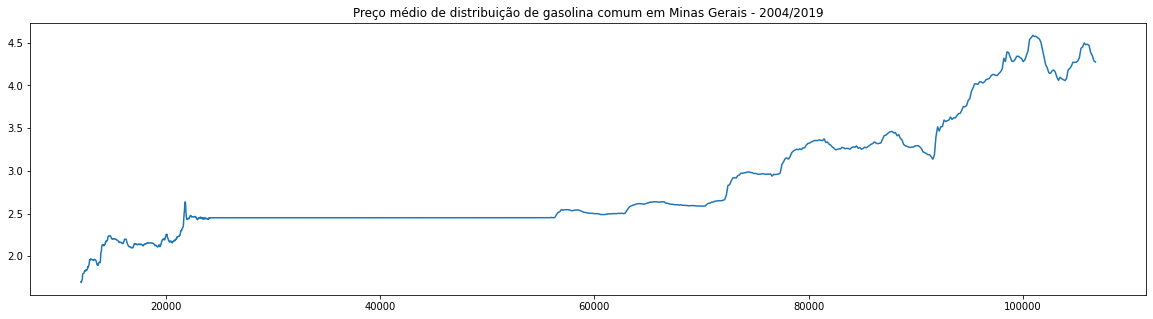

In [19]:
plt.figure(figsize=(20, 5))
plt.title('Preço médio de distribuição de gasolina comum em Minas Gerais - 2004/2019')
plt.plot(data.query("estado == 'MINAS GERAIS' and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
plt.show()

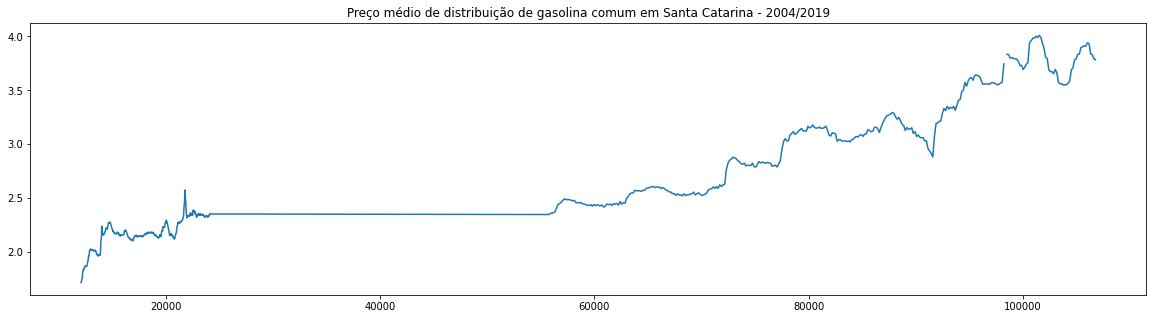

In [20]:
plt.figure(figsize=(20, 5))
plt.title('Preço médio de distribuição de gasolina comum em Santa Catarina - 2004/2019')
plt.plot(data.query("estado == 'SANTA CATARINA' and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
plt.show()

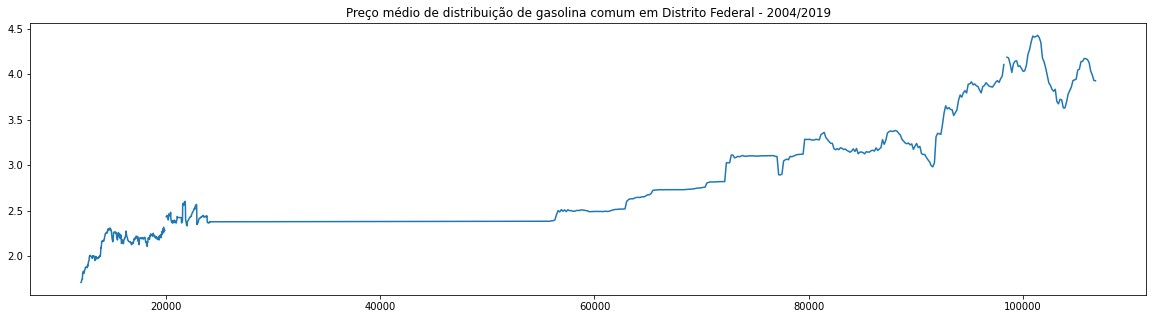

In [21]:
plt.figure(figsize=(20, 5))
plt.title('Preço médio de distribuição de gasolina comum em Distrito Federal - 2004/2019')
plt.plot(data.query("estado == 'DISTRITO FEDERAL' and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
plt.show()

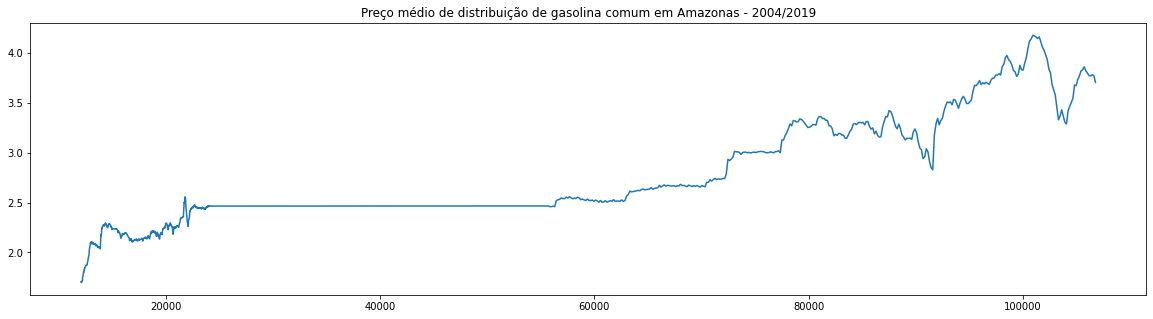

In [22]:
plt.figure(figsize=(20, 5))
plt.title('Preço médio de distribuição de gasolina comum em Amazonas - 2004/2019')
plt.plot(data.query("estado == 'AMAZONAS' and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
plt.show()

Optei por selecionar um estado de cada região para plotar o gráfico e vemos que a hipotése levantada sobre a sobreposição dos gráficos é válida.

Existe um padrão entre todos os gráficos. O valor oscila no começo da série e na sequência o valor permanece constante durante quase toda a primeira metade do gráfico perto de R$ 2.50 e na segunda metade o valor começa a subir com oscilações e para próximo de RS 4.00.

Uma outra observação que pode ser feita é se a média dos valores por estado podem representar a região.

In [23]:
produtos = data.produto.unique()
regioes = data.regiao.unique()

for regiao in regioes:
    for produto in produtos:
        total = data.query("regiao == @regiao and produto == @produto").shape[0]
        print(f"{regiao} - {produto}: {total} registros")

CENTRO OESTE - ETANOL HIDRATADO: 3140 registros
CENTRO OESTE - GASOLINA COMUM: 3140 registros
CENTRO OESTE - GLP: 3137 registros
CENTRO OESTE - GNV: 1523 registros
CENTRO OESTE - ÓLEO DIESEL: 3140 registros
CENTRO OESTE - ÓLEO DIESEL S10: 1349 registros
NORDESTE - ETANOL HIDRATADO: 7064 registros
NORDESTE - GASOLINA COMUM: 7065 registros
NORDESTE - GLP: 7061 registros
NORDESTE - GNV: 5575 registros
NORDESTE - ÓLEO DIESEL: 7065 registros
NORDESTE - ÓLEO DIESEL S10: 3039 registros
NORTE - ETANOL HIDRATADO: 5404 registros
NORTE - GASOLINA COMUM: 5494 registros
NORTE - GLP: 5494 registros
NORTE - GNV: 457 registros
NORTE - ÓLEO DIESEL: 5494 registros
NORTE - ÓLEO DIESEL S10: 2359 registros
SUDESTE - ETANOL HIDRATADO: 3140 registros
SUDESTE - GASOLINA COMUM: 3140 registros
SUDESTE - GLP: 3139 registros
SUDESTE - GNV: 3136 registros
SUDESTE - ÓLEO DIESEL: 3140 registros
SUDESTE - ÓLEO DIESEL S10: 1352 registros
SUL - ETANOL HIDRATADO: 2354 registros
SUL - GASOLINA COMUM: 2355 registros
SUL -

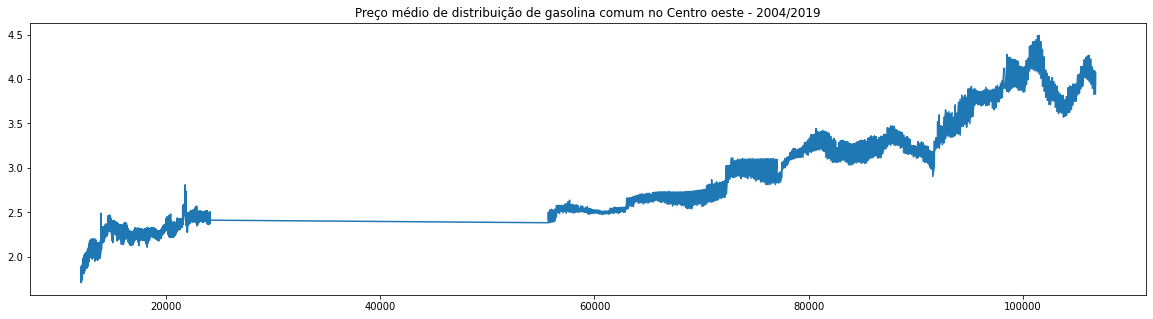

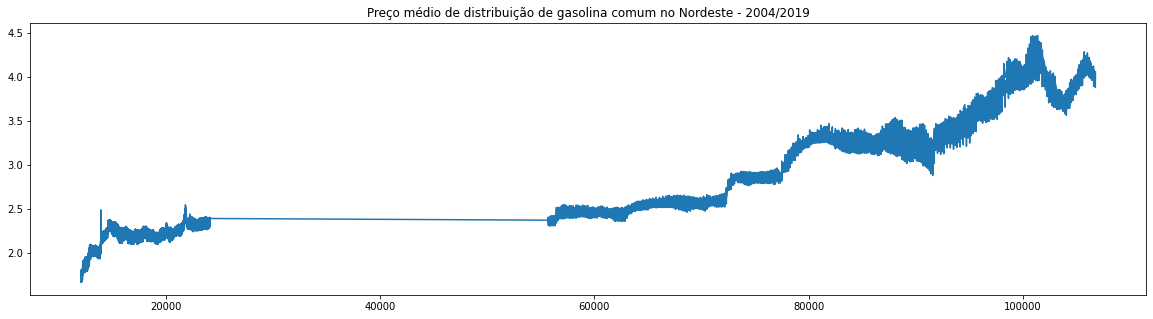

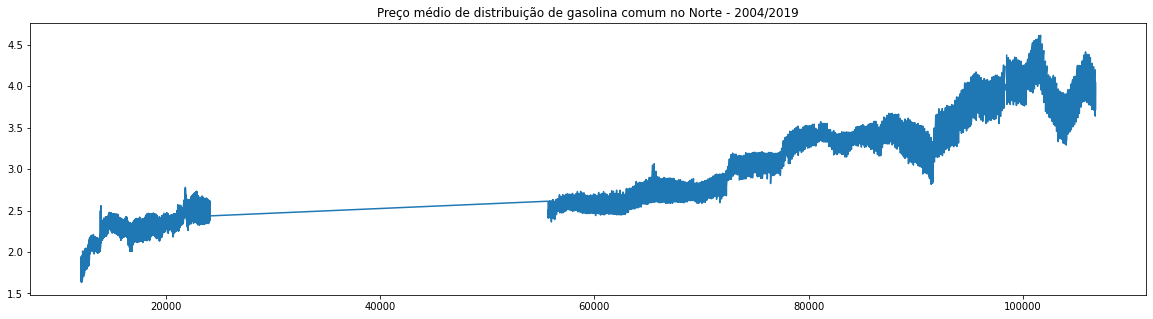

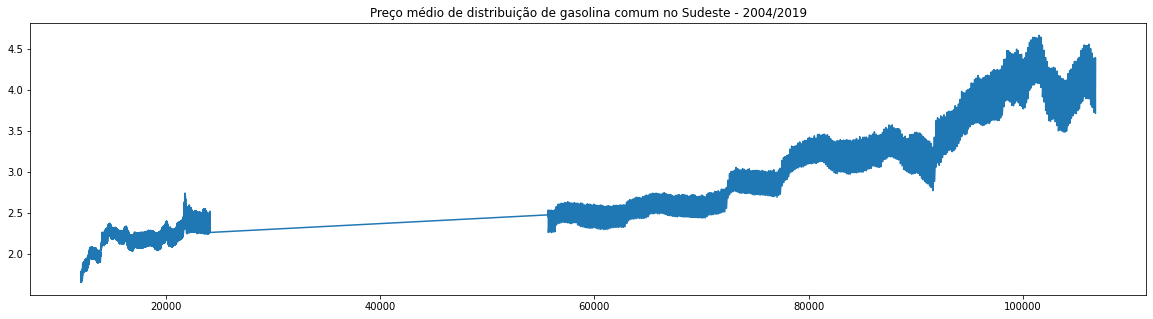

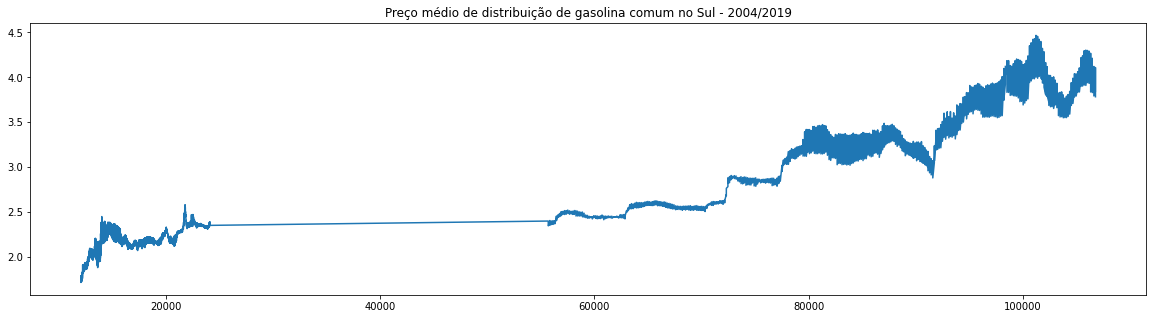

In [24]:
for regiao in regioes:
    plt.figure(figsize=(20, 5))
    plt.title(f'Preço médio de distribuição de gasolina comum no {regiao.capitalize()} - 2004/2019')
    plt.plot(data.query("regiao == @regiao and produto == 'GASOLINA COMUM'").precoMedioDistribuicao)
    plt.show()

Aqui acontece o mesmo fenômeno do gráfico plotado para o dataset inteiro e isso se deu pelo mesmo motivo. A consulta por região traz todos os estados que pertencem àquela região, logo, os gráficos ficarão sobrepostos mais uma vez.

Se quiséssemos avaliar os dados dos combustíveis por região, teríamos que tirar uma média de cada registro de todos os estados de cada região e criar um novo `DataFrame`.

Por enquanto, vamos escolher um estado e um tipo de combustível e continuar a nossa análise.

In [25]:
for produto in produtos:
    total = data.query("estado == 'ALAGOAS' and produto == @produto").shape[0]
    print(f"Alagoas - {produto}: {total} registros")

Alagoas - ETANOL HIDRATADO: 785 registros
Alagoas - GASOLINA COMUM: 785 registros
Alagoas - GLP: 784 registros
Alagoas - GNV: 774 registros
Alagoas - ÓLEO DIESEL: 785 registros
Alagoas - ÓLEO DIESEL S10: 337 registros


Vamos seguir com os dados de Alagoas e observar os dados relacionados à gasolina comum. Mais uma vez, vamos observar se temos dados nulos e pensar na melhor abordagem para tratá-los.

In [26]:
data_al_gas = data.query("estado == 'ALAGOAS' and produto == 'GASOLINA COMUM'")
data_al_gas.head()

,dataFinal,regiao,estado,produto,numeroPostosPesquisados,unidadeDeMedida,precoMedioRevenda,desvioPadraoRevenda,precoMinimoRevenda,precoMaximoRevenda,margemMediaRevenda,coefVariacaoRevenda,precoMedioDistribuicao,desvioPadraoDistribuicao,precoMinimoDistribuicao,precoMaximoDistribuicao,coefVariacaoDistribuicao,mes,ano
12068,2004-05-15,NORDESTE,ALAGOAS,GASOLINA COMUM,106,R$/l,2.090,0.034,2.0,2.159,0.350,0.016,1.740,0.042,1.6789,1.9180,0.024,5,2004
12095,2004-05-22,NORDESTE,ALAGOAS,GASOLINA COMUM,109,R$/l,2.089,0.035,2.0,2.170,0.351,0.017,1.738,0.034,1.6700,1.8874,0.020,5,2004
12122,2004-05-29,NORDESTE,ALAGOAS,GASOLINA COMUM,107,R$/l,2.089,0.035,2.0,2.170,0.367,0.017,1.722,0.035,1.6600,1.8874,0.020,5,2004
12149,2004-06-05,NORDESTE,ALAGOAS,GASOLINA COMUM,108,R$/l,2.089,0.037,2.0,2.190,0.366,0.018,1.723,0.042,1.6480,1.9376,0.024,5,2004
12176,2004-06-12,NORDESTE,ALAGOAS,GASOLINA COMUM,106,R$/l,2.089,0.037,2.0,2.190,0.354,0.018,1.735,0.042,1.6153,1.8874,0.024,6,2004


In [27]:
data_al_gas.isnull().sum()

dataFinal                   0
regiao                      0
estado                      0
produto                     0
numeroPostosPesquisados     0
unidadeDeMedida             0
precoMedioRevenda           0
desvioPadraoRevenda         0
precoMinimoRevenda          0
precoMaximoRevenda          0
margemMediaRevenda          0
coefVariacaoRevenda         0
precoMedioDistribuicao      0
desvioPadraoDistribuicao    0
precoMinimoDistribuicao     0
precoMaximoDistribuicao     0
coefVariacaoDistribuicao    0
mes                         0
ano                         0
dtype: int64

Bom, como não temos valores nulos nós vamos seguir com a análise. 

Dos valores que temos a nossa disposição, talvez o mais interessante seja prever o preço médio. Podemos partir da premissa que essa atividade tem como objetivo entregar ao consumidor final informações sobre preços de combustível. Portanto, é interessante para nós elegermos como nosso target o preço médio de revenda, pois esse é o número que chega aos postos de gasolina.

## Características das séries temporais

Vamos analisar as características de uma série temporal e ver o que podemos inferir.

In [28]:
plt.rcParams["figure.figsize"] = (10,5)

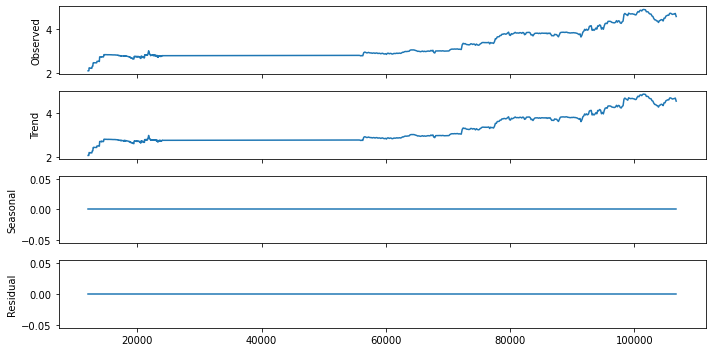

In [29]:
decomposition = seasonal_decompose(data_al_gas.precoMedioRevenda, model='additive', freq=1)
decomposition.plot()
plt.show()

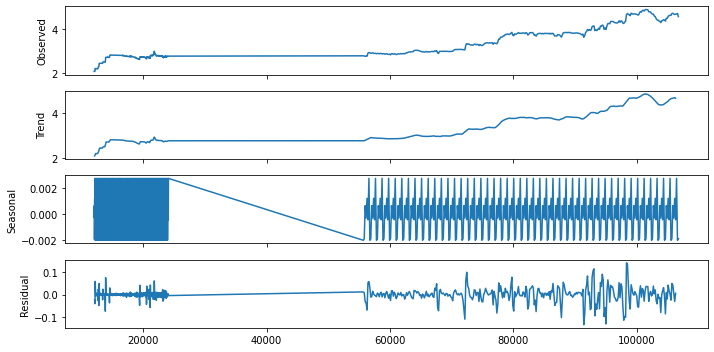

In [30]:
decomposition = seasonal_decompose(data_al_gas.precoMedioRevenda, model='additive', freq=7)
decomposition.plot()
plt.show()

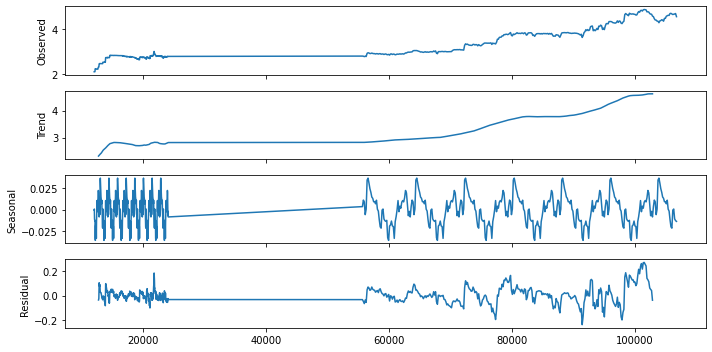

In [31]:
decomposition = seasonal_decompose(data_al_gas.precoMedioRevenda, model='additive', freq=52)
decomposition.plot()
plt.show()

Os gráficos exibem tendência, sazonalidade e o resíduo - ou ruído - de uma série temporal.

No primeiro gráfico, com frequência igual a 1, não é possível ver de forma clara como as características da série estão se comportando.

Já no gráfico seguinte, com frequência igual a 7, as características começam a ficar mais evidentes onde a tendência começa a suavizar e a sazonalidade começa a definir padrões que surgem nos dados.

Por último, o gráfico foi plotado com frequência 52, buscando obter uma visualização anual e vemos que a tendência fica mais suavizada, seguindo a série. A sazonalidade adota diferentes padrões ao longo do tempo nos mostrando um intervalo de frequência de alta e queda nos primeiros anos seguido de uma linearidade e depois volta a ter uma frequência de altas e quedas nos preços, mas com um intervalo maior entre os picos.

Os resíduos estão com um comportamento bem semelhante com a sazonalidade em todos os gráficos.

## Analisando correlações

No objetivo de escolher as variáveis mais relevantes, observar as correlações é uma abordagem que nos dá essa informação, pois isso fará com que possamos lidar apenas com informações relevantes acerca do contexto.

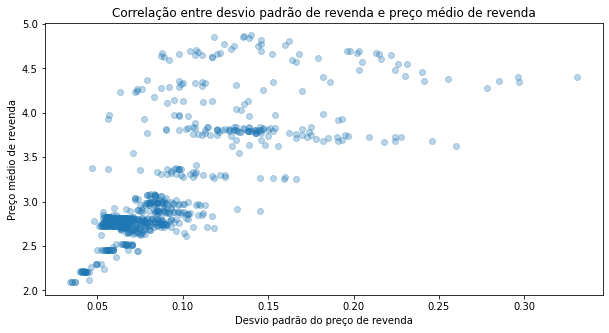

In [32]:
plt.figure(figsize=(10, 5))
plt.title('Correlação entre desvio padrão de revenda e preço médio de revenda')
plt.scatter(x=data_al_gas.desvioPadraoRevenda, y=data_al_gas.precoMedioRevenda, alpha=0.3)
plt.xlabel('Desvio padrão do preço de revenda')
plt.ylabel('Preço médio de revenda')
plt.show()

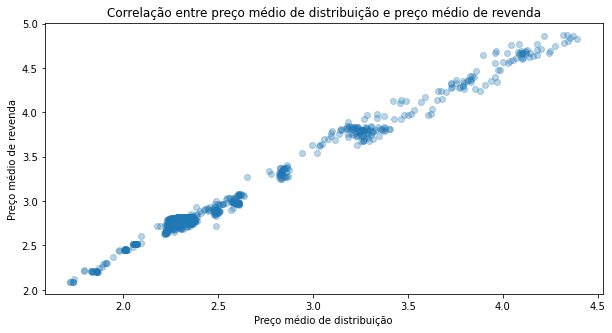

In [33]:
plt.figure(figsize=(10, 5))
plt.title('Correlação entre preço médio de distribuição e preço médio de revenda')
plt.scatter(x=data_al_gas.precoMedioDistribuicao, y=data_al_gas.precoMedioRevenda, alpha=0.3)
plt.xlabel('Preço médio de distribuição')
plt.ylabel('Preço médio de revenda')
plt.show()

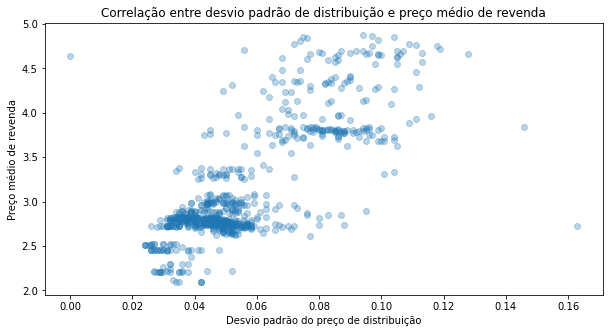

In [34]:
plt.figure(figsize=(10, 5))
plt.title('Correlação entre desvio padrão de distribuição e preço médio de revenda')
plt.scatter(x=data_al_gas.desvioPadraoDistribuicao, y=data_al_gas.precoMedioRevenda, alpha=0.3)
plt.xlabel('Desvio padrão do preço de distribuição')
plt.ylabel('Preço médio de revenda')
plt.show()

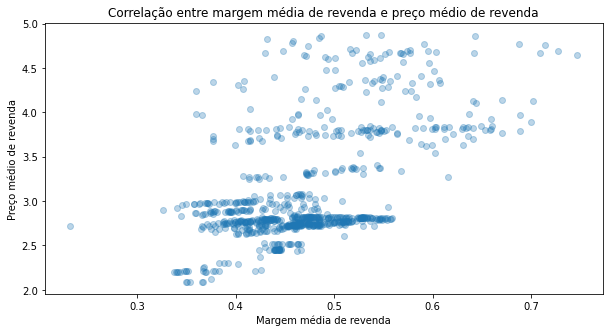

In [35]:
plt.figure(figsize=(10, 5))
plt.title('Correlação entre margem média de revenda e preço médio de revenda')
plt.scatter(x=data_al_gas.margemMediaRevenda, y=data_al_gas.precoMedioRevenda, alpha=0.3)
plt.xlabel('Margem média de revenda')
plt.ylabel('Preço médio de revenda')
plt.show()

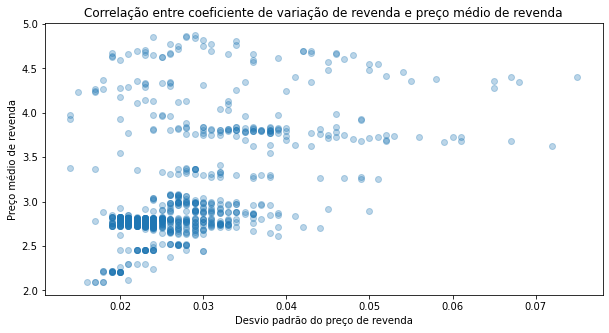

In [36]:
plt.figure(figsize=(10, 5))
plt.title('Correlação entre coeficiente de variação de revenda e preço médio de revenda')
plt.scatter(x=data_al_gas.coefVariacaoRevenda, y=data_al_gas.precoMedioRevenda, alpha=0.3)
plt.xlabel('Desvio padrão do preço de revenda')
plt.ylabel('Preço médio de revenda')
plt.show()

## Comentando as correlações 2 a 2

O primeiro gráfico exibe uma correlação entre o preço médio de revenda e o seu desvio padrão. Existe uma correlação alta, mas não muito. As primeiras instâncias apresentam um correlação bem forte e, conforme o desenho avança, as instância vão ficando mais esparsas.

Observando o segundo gráfico, vemos uma coorelação bem alta entre o preço médio de distribuição e o preço médio de revenda. É uma correlação óbvia dentro do escopo porque o preço de revenda é uma consequência do preço de distribuição

No terceiro gráfico temos a correlação entre preço médio de revenda e o desvio padrão do preço de distribuição e o comportamento é semelhante ao do primeiro gráfico, mostrando uma correlação bem parecida com a correlação entre preço médio de revenda e seu desvio padrão.

Nos dois últimos gráficos vemos que a correlação entre o preço médio de revenda e sua margem média e coeficiente de variação é mais baixa que os gráficos anteriores, apesar de existirem algumas regiões onde as instâncias estão agrupadas mostrando que independente do valor que o desvio padrão assuma, o preço médio mantém seu comportamento atual.


## Correlação utilizando mapa de calor

Depois de observar algumas variáveis, vamos observar o dataset como um todo.

In [37]:
corr_data_al_gas = data_al_gas.corr()

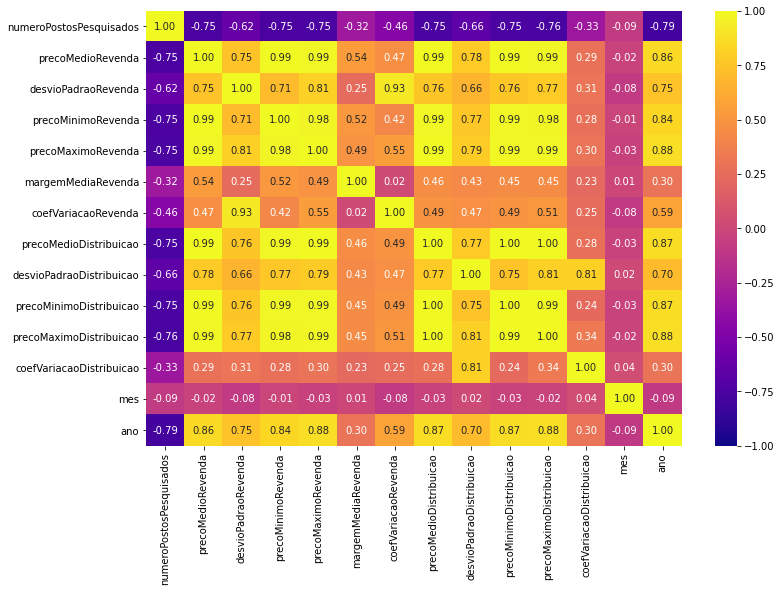

In [38]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_data_al_gas,
    linecolor='black',
    vmin=-1, vmax=1, center=0,
    annot=True, fmt='.2f', cmap=plt.cm.plasma
)
plt.show()

O heatmap confirma nossas análises de correlação 2 a 2, mostrando que as características estatísticas tem um pouco menos de correlação do que os demais atributos em relação ao preço médio de revenda.

## Organizando os dados para treinar os modelos de regressão

Depois do trabalho de análise, vamos agora organizar nossos dados para treinar nossos modelos. Na célula abaixo tem a implementação de uma função que tem como objetivo preparar uma série temporal multivariada para o processo de aprendizado supervisionado, como o prórpio nome da função sugere. A função recebe como parâmetros o dataset e o número de observações de atraso desejado tanto para as variáveis que serão nosso X quanto as que serão y.

In [39]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Aqui foi criado um subset do dataset que estávamos analisando anteriormente. Nesse subset está contido apenas as variáveis que foram escolhidas para treinar o modelo.

In [40]:
selected_fields = {
    'precoMinimoRevenda': data_al_gas.precoMinimoRevenda.values,
    'precoMaixmoRevenda': data_al_gas.precoMaximoRevenda.values,
    'precoMinimoDistribuicao': data_al_gas.precoMinimoDistribuicao.values,
    'precoMaximoDistribuicao':data_al_gas.precoMaximoDistribuicao.values,
    'precoMedioDistribuicao': data_al_gas.precoMedioDistribuicao.values,
    'precoMedioRevenda': data_al_gas.precoMedioRevenda.values
}
subset = pd.DataFrame(selected_fields)

In [41]:
subset.head()

,precoMinimoRevenda,precoMaixmoRevenda,precoMinimoDistribuicao,precoMaximoDistribuicao,precoMedioDistribuicao,precoMedioRevenda
0,2.0,2.159,1.6789,1.9180,1.740,2.090
1,2.0,2.170,1.6700,1.8874,1.738,2.089
2,2.0,2.170,1.6600,1.8874,1.722,2.089
3,2.0,2.190,1.6480,1.9376,1.723,2.089
4,2.0,2.190,1.6153,1.8874,1.735,2.089


A função `series_to_supervised()` é chamada retornando um outro `DataFrame` com as observações de atraso. Foi passado como parâmetro apenas o subset e os outros parâmetros ficaram com os valores padrão que, para as observações de atraso, é 1. Ou seja, a tarefa será prever o preço médio de revenda da próxima semana.

In [42]:
new_data = series_to_supervised(subset)
new_data.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,2.00,2.159,1.6789,1.9180,1.740,2.090,2.00,2.17,1.6700,1.8874,1.738,2.089
2,2.00,2.170,1.6700,1.8874,1.738,2.089,2.00,2.17,1.6600,1.8874,1.722,2.089
3,2.00,2.170,1.6600,1.8874,1.722,2.089,2.00,2.19,1.6480,1.9376,1.723,2.089
4,2.00,2.190,1.6480,1.9376,1.723,2.089,2.00,2.19,1.6153,1.8874,1.735,2.089
5,2.00,2.190,1.6153,1.8874,1.735,2.089,2.05,2.28,1.6800,1.8711,1.744,2.119
6,2.05,2.280,1.6800,1.8711,1.744,2.119,2.14,2.30,1.6995,2.0076,1.797,2.223
7,2.14,2.300,1.6995,2.0076,1.797,2.223,2.10,2.30,1.7000,1.9015,1.796,2.216
8,2.10,2.300,1.7000,1.9015,1.796,2.216,2.14,2.29,1.7049,2.0326,1.830,2.213
9,2.14,2.290,1.7049,2.0326,1.830,2.213,2.10,2.29,1.7670,2.0326,1.831,2.210
10,2.10,2.290,1.7670,2.0326,1.831,2.210,2.13,2.29,1.7695,1.9423,1.837,2.206


A seguir separo meu `X` e meu `y` e realizo a reescala dos dados. Depois disso ploto a série temporal mostrando a divisão de treino e teste dos dados. É uma boa maneira de verificar se a divisão dos dados em treino teste foi realizado de forma correta pois, se tratando de séries temporais, não podemos perder a dependência temporal que os dados possuem.

In [43]:
X = new_data.loc[:,['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)']]
y = new_data['var6(t)']

In [44]:
X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

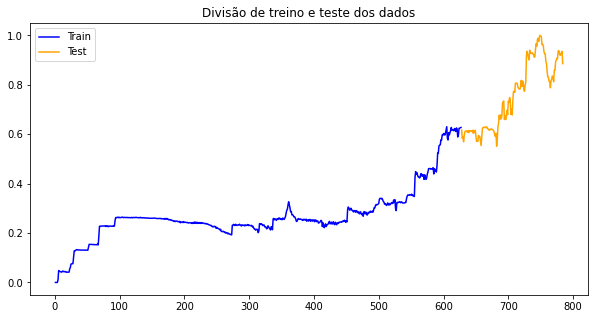

In [46]:
plt.title('Divisão de treino e teste dos dados')
plt.plot(y_train, color='Blue', label='Train')
plt.plot(y_test, color='Orange', label='Test')
plt.legend()
plt.show()

## Treinando modelos com parâmetros padrão

Vamos utilizar 4 modelos de regressão e comparar suas performances:

- Regressão Linear
- Random Forest
- Árvore de Decisão
- MLP

In [47]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression_pred = linear_regression.predict(X_test)

In [48]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)

In [49]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)

In [50]:
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

## Observando a performance dos modelos pelos gráficos

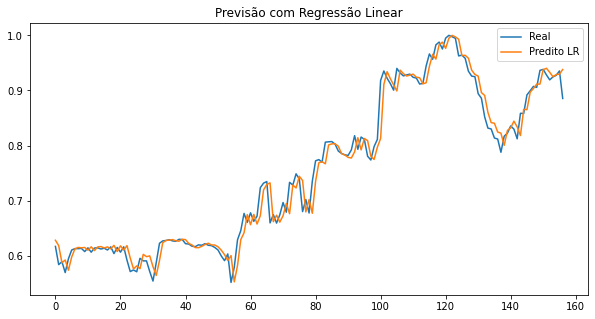

In [51]:
plt.title('Previsão com Regressão Linear')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(linear_regression_pred, label='Predito LR')
plt.legend()
plt.show()

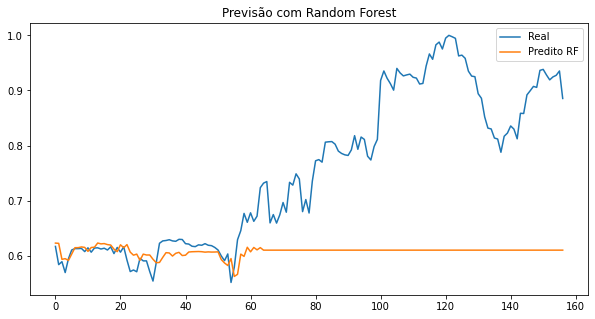

In [52]:
plt.title('Previsão com Random Forest')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(random_forest_pred, label='Predito RF')
plt.legend()
plt.show()

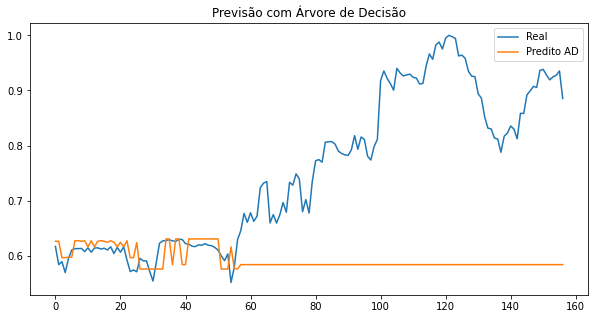

In [53]:
plt.title('Previsão com Árvore de Decisão')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(decision_tree_pred, label='Predito AD')
plt.legend()
plt.show()

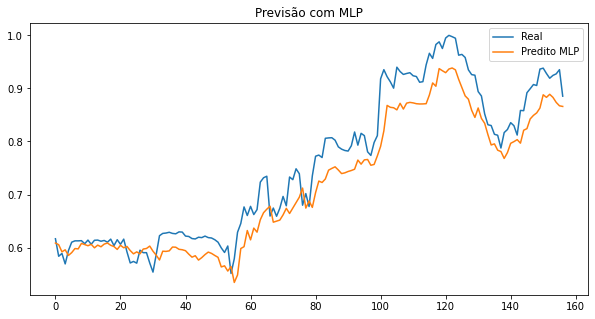

In [54]:
plt.title('Previsão com MLP')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(mlp_pred, label='Predito MLP')
plt.legend()
plt.show()

Os gráficos nos dão uma visão geral do que aconteceu durante o treinamento. A regressão linear teve melhor performance, seguida da MLP. As random forest e a árvore de decisão tiveram um desempenho bem abaixo.

Vamos observar os desempenhos de forma numérica.

## Observando os resultados a partir das métricas

Quando estamos trabalhando em problemas de regressão, além de atividade de aprendizado supervisionado não ser mais de classificação, a forma de avaliar quão bom um modelo é também muda. Enquanto na classificação o nosso interesse é saber a acurácia - e outras métricas que giram em torno de taxa de acerto - aqui no trabalho de regressão nós estamos interessados em saber o quanto nosso modelo erra. No fim das contas o propósito é avaliar em ambos os casos, mas a natureza de cada problema requer abordagens apropriadas.

As métricas utilizadas aqui serão:

- MAE: Mean Absolute Error (Erro Médio Absoluto)
- MSE: Mean Squared Error (Erro Médio Quadrado)
- RMSE: Root Mean Squared Error (Raiz do Erro Médio Quadrado)
- MAPE Mean Absolute Percantege Error (Porcentagem do Erro Médio Absoluto)

In [55]:
print('MAE - Erro Médio Absoluto')
print(f'Regressão Linear: {round(mean_absolute_error(y_test, linear_regression_pred) ,2)}')
print(f'Random Forest: {round(mean_absolute_error(y_test, random_forest_pred), 2)}')
print(f'Árvore de Decisão: {round(mean_absolute_error(y_test, decision_tree_pred), 2)}')
print(f'MLP: {round(mean_absolute_error(y_test, mlp_pred), 2)}')

MAE - Erro Médio Absoluto
Regressão Linear: 0.02
Random Forest: 0.15
Árvore de Decisão: 0.17
MLP: 0.04


In [56]:
print('MSE - Erro Médio Quadrático')
print(f'Regressão Linear: {round(mean_squared_error(y_test, linear_regression_pred), 2)}')
print(f'Random Forest: {round(mean_squared_error(y_test, random_forest_pred), 2)}')
print(f'Árvore de Decisão: {round(mean_squared_error(y_test, decision_tree_pred), 2)}')
print(f'MLP: {round(mean_squared_error(y_test, mlp_pred), 2)}')

MSE - Erro Médio Quadrático
Regressão Linear: 0.0
Random Forest: 0.04
Árvore de Decisão: 0.05
MLP: 0.0


In [57]:
print('RMSE - Raiz do Erro Médio Quadrático')
print(f'Regressão Linear: {round(np.sqrt(mean_absolute_error(y_test, linear_regression_pred)), 2)}')
print(f'Random Forest: {round(np.sqrt(mean_absolute_error(y_test, random_forest_pred)), 2)}')
print(f'Árvore de Decisão: {round(np.sqrt(mean_absolute_error(y_test, decision_tree_pred)), 2)}')
print(f'MLP: {round(np.sqrt(mean_absolute_error(y_test, mlp_pred)), 2)}')

RMSE - Raiz do Erro Médio Quadrático
Regressão Linear: 0.12
Random Forest: 0.39
Árvore de Decisão: 0.41
MLP: 0.2


In [58]:
def mean_absolute_percentage_error(y_test, predict):
    soma = 0
    for i in range(len(y_test)):
        soma += abs((y_test[i] - predict[i]) / y_test[i]) * 100
    media_erro = soma / len(y_test)
    return media_erro

In [59]:
y_test_no_index = y_test.reset_index(drop=True)

print('MAPE - Porcentagem do Erro Médio Absoluto')
print(f'Regressão Linear: {round(mean_absolute_percentage_error(y_test_no_index+1, linear_regression_pred+1)**(1/2), 2)}')
print(f'Random Forest: {round(mean_absolute_percentage_error(y_test_no_index+1, random_forest_pred+1)**(1/2), 2)}')
print(f'Árvore de Decisão: {round(mean_absolute_percentage_error(y_test_no_index+1, decision_tree_pred+1)**(1/2), 2)}')
print(f'MLP: {round(mean_absolute_percentage_error(y_test_no_index+1, mlp_pred+1)**(1/2), 2)}')

MAPE - Porcentagem do Erro Médio Absoluto
Regressão Linear: 0.93
Random Forest: 2.84
Árvore de Decisão: 3.01
MLP: 1.47


### Um comentário técnico sobre gráficos e o MAPE 

Antes de comentar sobre os resultados, vou comentar sobre a linha 1 da célula acima. Quando dividimos os dados de uma série temporal em treino e teste nós não permitimos que os dados sejam embaralhados para que possamos manter a dependência temporal, a consequência disso é que cada nova porção dos dados - que é um objeto `Series` - mantém a sua indexação natural. Ou seja, imagine que seu dataset é

`[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

e você o divide em `X` e `y` na proporção 80/20 sem embaralhar. O resultado é que `X` vai ter 0 como primeiro índice e `y` vai ter 8 como primeiro índice.

Abstraindo esse exemplo para o resultado da operação do `train_test_split` com `shuffle=False`, temos o mesmo efeito nas porções de treino e teste. Para sanar isso, utiliza-se o método `reset_index(drop=True)` que leva o conjunto para iniciar a indexação do valor 0.

Nos gráficos, algumas vezes é necessário reiniciar a indexação para visualizar duas séries a partir do mesmo ponto. No caso do MAPE, a implementação não prevê esse tipo de comportamento fazendo com que tenhamos que passar o conjunto reindexado.

## Discutindo os resultados

|Modelo/Métrica      |MAE     |MSE    |RMSE    |MAPE    |
|--------------------|--------|-------|--------|--------|
|**Regressão Linear**|**0.02**|**0.0**|**0.12**|**0.93**|
|MLP                 |0.05    |0.0    |0.23    |1.73    |
|Random Forest       |0.15    |0.04   |0.39    |2.83    |
|Árvore de Decisão   |0.17    |0.05   |0.41    |3.01    |

O modelo de regressão linear teve a melhor performance entre os 4 algoritmos em todas as métricas. A Random Forest teve melhor desempanho que a Árvore de Decisão mas ficou atrás da MLP. 

O desempenho da Random Forest chama a atenção porque esse algoritmo tem tido a melhor performance na grande parte das soluções de Machine Learning para os mais diversos tipos de problemas.

Observando os resultados nos gráficos podemos ver que a Regressão Linear e a MLP conseguiram uma boa aproximação do desenho da série real com destaque para a Regressão Linear, que teve a melhor aproximação. A Árvore de Decisão e a Random Forest obtiveram uma certa aproximação do desenho da série real nos primeiros 40% dos dados, aproximadamente, e para o restante dos dados não houve um desempenho satisfatório.


## Otimização de parâmetros

Aqui vamos treinar os mesmos 4 modelos da seção anterior porém tentando buscar os melhores parâmetros para cada um deles. A proporção dos dados de treino e teste continua 80/20 e as métricas utilizadas serão as mesmas da seção anterior.

Para a otimização de parâmetros vamos adotar o método **Randomized Search** para todos os modelos devido ao seu baixo tempo de execução. Em seguida vamos pegar o objeto resultante da otimização dos respectivos modelos e treiná-los com os dados de treino e os dados de teste. 

#### Otimizando parâmetros para Regressão Linear

In [60]:
lr_params = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
}
scores = [
        'explained_variance',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'neg_median_absolute_error', 'r2'
    ]

In [61]:
linear_regression_estimator = RandomizedSearchCV(
    LinearRegression(),
    param_distributions=lr_params,
    scoring=scores, verbose=100,
    refit='neg_mean_squared_error',
    return_train_score=False
)

In [62]:
linear_regression_estimator.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV]  normalize=True, fit_intercept=True, copy_X=True, explained_variance=0.994, neg_mean_absolute_error=-0.003, neg_mean_squared_error=-0.000, neg_mean_squared_log_error=-0.000, neg_median_absolute_error=-0.001, r2=0.993, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV]  normalize=True, fit_intercept=True, copy_X=True, explained_variance=0.931, neg_mean_absolute_error=-0.003, neg_mean_squared_error=-0.000, neg_mean_squared_log_error=-0.000, neg_median_absolute_error=-0.002, r2=0.931, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV]  normal

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'normalize': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None,
                   refit='neg_mean_squared_error', return_train_score=False,
                   scoring=['explained_variance', 'neg_mean_absolute_error',
                            'neg_mean_squared_error',
                            'neg_mean_squared_log_error',
                            'neg_median_absolute_error', 'r2'],
                   verbose=100)

In [63]:
print('BEST PARAMETERS:')
for key, value in linear_regression_estimator.best_params_.items():
    print(f'{key}: {value}')

BEST PARAMETERS:
normalize: True
fit_intercept: True
copy_X: True


In [64]:
print('BEST ESTIMATOR:')
linear_regression_estimator.best_estimator_

BEST ESTIMATOR:


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [65]:
print('BEST RESULT:')
print(linear_regression_estimator.best_score_)

BEST RESULT:
-0.00016001686136854227


#### Treinando Regressor Linear com os melhoes parâmetros dados pelo Randomized Search

In [66]:
linear_regression_optimized = linear_regression_estimator.best_estimator_
linear_regression_optimized.fit(X_train, y_train)
lr_optimized_pred = linear_regression_optimized.predict(X_test)

#### Otimizando MLP para regressão

In [67]:
mlp_params = {
    'hidden_layer_sizes': [(30), (50, 30), (50, 100), (30, 50, 100), (50, 150, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000]
}

In [68]:
scores = [
        'explained_variance',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_median_absolute_error', 'r2'
    ]

In [69]:
mlp_estimator = RandomizedSearchCV(
    estimator=MLPRegressor(),
    param_distributions=mlp_params,
    scoring=scores,
    refit='neg_mean_squared_error',
    return_train_score=False
)

In [70]:
mlp_estimator.fit(X, y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          rand...
                                        'hidden_layer_sizes': [30, (50, 30),
                                                               (50, 100),
                                      

In [71]:
print('BEST PARAMETERS:')
for key, value in mlp_estimator.best_params_.items():
    print(f'{key}: {value}')

BEST PARAMETERS:
solver: lbfgs
max_iter: 2000
hidden_layer_sizes: (30, 50, 100)
activation: identity


In [72]:
print('BEST ESTIMATOR:')
mlp_estimator.best_estimator_

BEST ESTIMATOR:


MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(30, 50, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [73]:
print('BEST RESULT:')
print(mlp_estimator.best_score_)

BEST RESULT:
-0.00023589902262504905


#### Treinando MLP para regressão com os melhores parâmetros dados pelo Randomized Search

In [78]:
mlp_optimized = mlp_estimator.best_estimator_
mlp_optimized.fit(X_train, y_train)
mlp_optimized_pred = mlp_optimized.predict(X_test)

#### Otimizando Random Forest

In [76]:
rf_params = {
    'n_estimators': [50, 100, 150],
    'criterion': ['mse', 'mae'],
    'max_depth': [None, 5, 7, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True, False],
}

random_forest_estimator = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=rf_params,
    scoring=scores,
    refit='neg_mean_squared_error',
    return_train_score=False
)

In [77]:
random_forest_estimator.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [79]:
print('BEST PARAMETERS:')
for key, value in random_forest_estimator.best_params_.items():
    print(f'{key}: {value}')

BEST PARAMETERS:
oob_score: False
n_estimators: 150
max_features: log2
max_depth: None
criterion: mse
bootstrap: True


In [80]:
print('BEST ESTIMATOR:')
random_forest_estimator.best_estimator_

BEST ESTIMATOR:


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Treinando Random Forest otimizada

In [86]:
random_forest_optimized = random_forest_estimator.best_estimator_
random_forest_optimized.fit(X_train, y_train)
random_forest_optimized_pred = random_forest_optimized.predict(X_test)

#### Otimizando Árvore de Decisão

In [82]:
dt_params = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_features': ['auto', 'sqrt', 'log2']
}

decision_tree_estimator = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(),
    param_distributions=dt_params,
    scoring=scores,
    refit='neg_mean_squared_error',
    return_train_score=False
)

In [83]:
decision_tree_estimator.fit(X, y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid

In [84]:
print('BEST PARAMETERS:')
for key, value in decision_tree_estimator.best_params_.items():
    print(f'{key}: {value}')

BEST PARAMETERS:
splitter: random
max_features: log2
criterion: mse


In [85]:
print('BEST ESTIMATOR')
decision_tree_estimator.best_estimator_

BEST ESTIMATOR


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='random')

In [89]:
decision_tree_optimized = decision_tree_estimator.best_estimator_
decision_tree_optimized.fit(X_train, y_train)
decision_tree_optimized_pred = decision_tree_optimized.predict(X_test)

### Um comentário técnico antes dos resultados

O resultado das otimizações nos dão várias estruturas que podem ser reutilizadas para quaisquer fins que desejar. Nesse caso aqui, para pegar a melhor configuração de cada modelo e treiná-lo com os dados de treino e avaliá-lo com os dados de teste, você pode usar o atributo `best_estimator_` do objeto `RandomizedSearch`, salvar em uma variável e rodar o `.fit()` e o `.predict()`. Veja um exemplo:

```
my_model = RandomizedSearch(...)
my_model.fit(X, y)
my_optimized_model = my_model.best_estimator_
my_optimized_model.fit(X_train, y_train)
my_optimized_model.predict(X_test)
```

Isso é possível porque `best_estimator_` guarda um objeto do algoritmo que você está otimizando com os melhores parâmetros que o otimizador conseguiu, como por exemplo:

```
type(decision_tree_estimator.best_estimator_)
>>> sklearn.tree._classes.DecisionTreeRegressor
```

### Visualizando os resultados dos modelos em gráficos

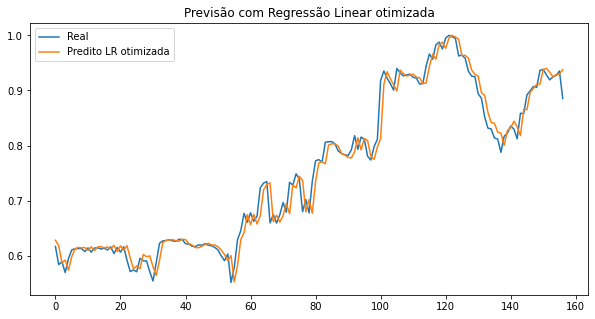

In [90]:
plt.title('Previsão com Regressão Linear otimizada')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(lr_optimized_pred, label='Predito LR otimizada')
plt.legend()
plt.show()

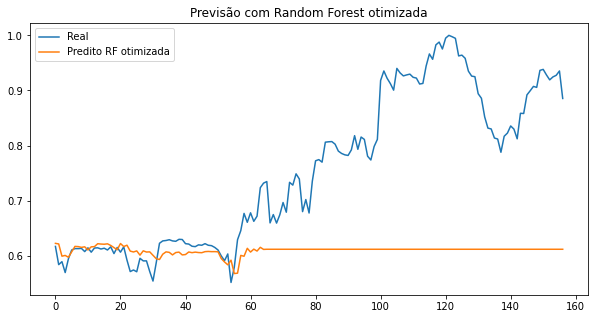

In [91]:
plt.title('Previsão com Random Forest otimizada')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(random_forest_optimized_pred, label='Predito RF otimizada')
plt.legend()
plt.show()

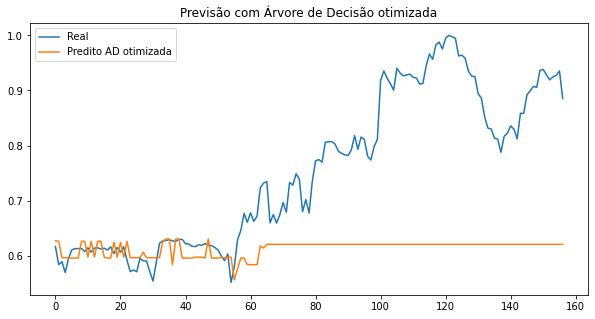

In [92]:
plt.title('Previsão com Árvore de Decisão otimizada')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(decision_tree_optimized_pred, label='Predito AD otimizada')
plt.legend()
plt.show()

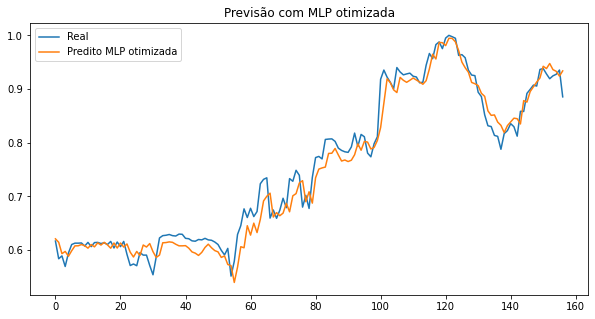

In [93]:
plt.title('Previsão com MLP otimizada')
plt.plot(y_test.reset_index(drop=True), label='Real')
plt.plot(mlp_optimized_pred, label='Predito MLP otimizada')
plt.legend()
plt.show()

Observando os gráficos podemos ver os desempenhos permanecem muito parecidos aos do experimento anterior com uma ligeira melhora na MLP. Aparentemente, a Regressão Linear mantém o mesmo desempenho de antes.

In [94]:
print('MAE - Erro Médio Absoluto')
print(f'Regressão Linear OP: {round(mean_absolute_error(y_test, lr_optimized_pred) ,2)}')
print(f'Random Forest OP: {round(mean_absolute_error(y_test, random_forest_optimized_pred), 2)}')
print(f'Árvore de Decisão OP: {round(mean_absolute_error(y_test, decision_tree_optimized_pred), 2)}')
print(f'MLP OP: {round(mean_absolute_error(y_test, mlp_optimized_pred), 2)}')

MAE - Erro Médio Absoluto
Regressão Linear OP: 0.02
Random Forest OP: 0.15
Árvore de Decisão OP: 0.15
MLP OP: 0.02


In [95]:
print('MSE - Erro Médio Quadrático')
print(f'Regressão Linear: {round(mean_squared_error(y_test, lr_optimized_pred), 2)}')
print(f'Random Forest: {round(mean_squared_error(y_test, random_forest_optimized_pred), 2)}')
print(f'Árvore de Decisão: {round(mean_squared_error(y_test, decision_tree_optimized_pred), 2)}')
print(f'MLP: {round(mean_squared_error(y_test, mlp_optimized_pred), 2)}')

MSE - Erro Médio Quadrático
Regressão Linear: 0.0
Random Forest: 0.04
Árvore de Decisão: 0.04
MLP: 0.0


In [96]:
print('RMSE - Raiz do Erro Médio Quadrático')
print(f'Regressão Linear: {round(np.sqrt(mean_absolute_error(y_test, lr_optimized_pred)), 2)}')
print(f'Random Forest: {round(np.sqrt(mean_absolute_error(y_test, random_forest_optimized_pred)), 2)}')
print(f'Árvore de Decisão: {round(np.sqrt(mean_absolute_error(y_test, decision_tree_optimized_pred)), 2)}')
print(f'MLP: {round(np.sqrt(mean_absolute_error(y_test, mlp_optimized_pred)), 2)}')

RMSE - Raiz do Erro Médio Quadrático
Regressão Linear: 0.12
Random Forest: 0.39
Árvore de Decisão: 0.38
MLP: 0.14


In [97]:
y_test_no_index = y_test.reset_index(drop=True)

print('MAPE - Porcentagem do Erro Médio Absoluto')
print(f'Regressão Linear: {round(mean_absolute_percentage_error(y_test_no_index+1, lr_optimized_pred+1)**(1/2), 2)}')
print(f'Random Forest: {round(mean_absolute_percentage_error(y_test_no_index+1, random_forest_optimized_pred+1)**(1/2), 2)}')
print(f'Árvore de Decisão: {round(mean_absolute_percentage_error(y_test_no_index+1, decision_tree_optimized_pred+1)**(1/2), 2)}')
print(f'MLP: {round(mean_absolute_percentage_error(y_test_no_index+1, mlp_optimized_pred+1)**(1/2), 2)}')

MAPE - Porcentagem do Erro Médio Absoluto
Regressão Linear: 0.93
Random Forest: 2.84
Árvore de Decisão: 2.8
MLP: 1.06


### Discutindo os resultados

|Modelo/Métrica         |MAE     |MSE    |RMSE    |MAPE    |
|-----------------------|--------|-------|--------|--------|
|**Regressão Linear**   |**0.02**|**0.0**|**0.12**|**0.93**|
|MLP                    |0.05    |0.0    |0.23    |1.73    |
|Random Forest          |0.15    |0.04   |0.39    |2.83    |
|Árvore de Decisão      |0.17    |0.05   |0.41    |3.01    |
|Regressão Linear OP    |0.02    |**0.0**|**0.12**|**0.93**|
|MLP OP                 |**0.0** |0.0    |0.14    |1.06    |
|Árvore de Decisão OP   |0.15    |0.04   |0.38    |2.80    |
|Random Forest OP       |0.15    |0.04   |0.39    |2.84    |

A tabela de resultados foi atualizada após a otimização. MLP e Árvore de Decisão obtiveram melhores resultados em comparação ao primeiro experimento, tendo a MLP superando a Regressão Linear na avaliação com o MAE e a Árvore de Decisão superando a Random Forest em todas as métricas. A Regressão Linear obteve o mesmo desempenho em ambos experimentos e continuou tendo desempenho superior aos outros modelos na maioria das métricas.

### Discussão sobre o trabalho
Esse conjunto de dados permite muito mais análise exploratória além do que foi feito neste trabalho pela possibilidade de definição de escopo como analisar outros índices como preço de distribuição; o preço de outros tipos de combustível por região - que requer uma transformação nos dados - ou por outro estado, etc. Aqui, foi fechado um escopo para analisar o preço médio de revenda da gasolina comum no estado de Alagoas e buscar prever o preço médio da semana seguinte.

Sobre as otimizações, vale lembrar que o método Random Search pode ignorar algumas combinações de parâmetros possíveis em um determinado espaço de soluções e vale lembrar também que o espaço de soluções não disponibiliza possibilidades para todos os parâmetros dos algoritmos e, mesmo assim, obtivemos resultados satisfatórios para a Regressão Linear e a MLP.

A estratégia que as Árvores de Decisão e as Random Forest utilizam para buscar um padrão nos dados pode não ser a mais adequadas para este problema, visto que séries temporais tendem a ter um grau de aleatoriedade alto e a série temporal analisada neste trabalho tem uma sazonalidade que muda ao longo do tempo e isso pode ser observado no gráfico onde a Árvore de Decisão e a Random Forest conseguem aprender o padrão inicial e, quando o padrão muda, elas não conseguem aprender mais porque a mudança de padrão foi muito grande.
